In [9]:
# Standard library imports
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt


# Machine learning and text processing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Load data
df = pd.read_csv('debates_2022.csv')

In [10]:
MIN_CHARS = 300
df['char_count'] = df['talk_text'].astype(str).str.len()
df = df[df['char_count'] >= MIN_CHARS]

In [11]:
NUM_FEATURES = 10000
custom_stopwords = ['europe', 'european', 'commission', 'commissioner', 'union', 'parliament', 
                     'political', 'council', 'need', 'thank', 'time', 'colleagues', 'today',
                     'like', 'want', 'think', 'report', 'dear', 'important', 'new', 'make']
custom_stopwords = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords))

tfidf = TfidfVectorizer(
    stop_words=custom_stopwords,         
    token_pattern=r'(?u)\b\w{3,}\b',
    max_df=0.70, 
    min_df=25, 
    max_features=NUM_FEATURES,            
)
X = tfidf.fit_transform(df['talk_text'])

In [12]:
# --- Dimensionality Reduction ---
svd = TruncatedSVD(n_components=500, random_state=42)
X_reduced = svd.fit_transform(X)

In [13]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_reduced)

silh_score = silhouette_score(X_reduced, labels)
print(silh_score)

0.017594933659631294


In [14]:
terms = tfidf.get_feature_names_out()
tfidf_dense = X.toarray()

print("Top terms per KMeans cluster:")
for cluster_id in range(k):
    doc_indices = np.where(labels == cluster_id)[0]
    avg_tfidf = np.mean(tfidf_dense[doc_indices], axis=0)
    top_indices = avg_tfidf.argsort()[::-1][:10]
    top_terms = [terms[i] for i in top_indices]
    
    print(f"Cluster {cluster_id + 1}: {', '.join(top_terms)}")

Top terms per KMeans cluster:
Cluster 1: women, violence, gender, rights, abortion, girls, equality, sexual, men, right
Cluster 2: ukraine, people, war, rights, russia, law, putin, democracy, country, russian
Cluster 3: climate, member, states, work, people, social, health, food, citizens, digital
Cluster 4: energy, gas, prices, renewable, price, crisis, electricity, nuclear, market, fossil


/var/folders/0h/c9mv4dpj66vf54cdhn01mxnh0000gn/T/ipykernel_77916/2925743136.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', k)


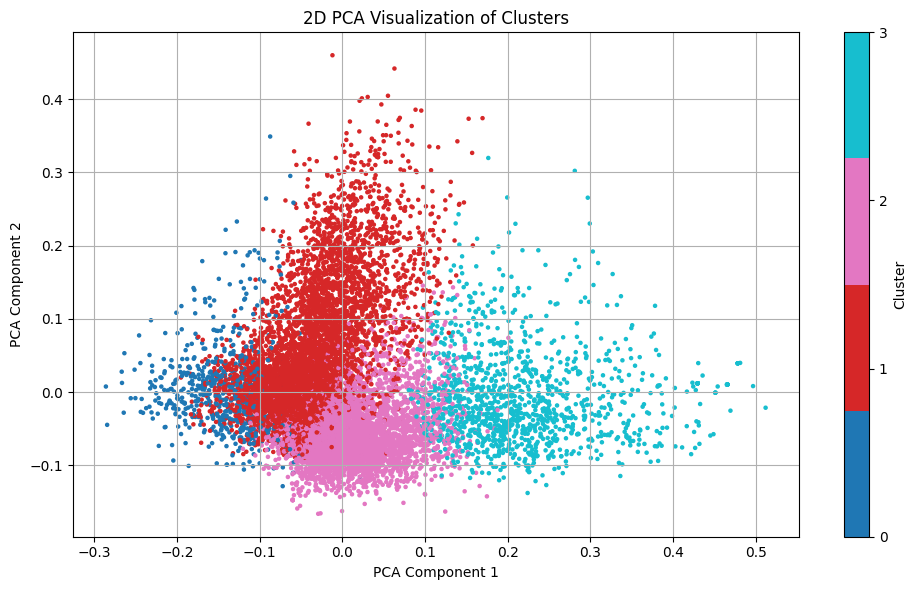


Top contributing terms per PCA component:
PCA Component 1: energy, gas, prices, crisis, price, renewable, electricity, climate, supply, nuclear
PCA Component 2: ukraine, war, russia, putin, russian, ukrainian, sanctions, refugees, peace, aggression


In [15]:
X_dense = X.toarray()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

# Visualize clusters
plt.figure(figsize=(10, 6))
cmap = plt.cm.get_cmap('tab10', k)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=cmap, s=5)
plt.title("2D PCA Visualization of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(k), label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Top contributing terms for each PCA component
terms = tfidf.get_feature_names_out()
print("\nTop contributing terms per PCA component:")
for i, component in enumerate(pca.components_):
    top_indices = np.argsort(component)[::-1][:10]
    top_terms = [terms[j] for j in top_indices]
    print(f"PCA Component {i+1}: {', '.join(top_terms)}")